In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sb
sb.set(style='white', context='notebook', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

import fitsio
from astropy.table import Table
from astropy.io import fits
from desitarget.sv3 import sv3_targetmask as targetmask
from desispec.io import specprod_root, read_spectra
from astropy.convolution import convolve, Gaussian1DKernel

In [3]:
# get list of secondary target observations 

infofile = '/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/zpix-sv3-dark.fits'
meta = Table(fitsio.read(infofile, 'ZCATALOG'))
strongLensTargs = meta[meta['SV3_SCND_TARGET'] & targetmask.scnd_mask['STRONG_LENS'] != 0]

In [20]:
strongLensTargs.keys()

['TARGETID',
 'HEALPIX',
 'SPGRPVAL',
 'Z',
 'ZERR',
 'ZWARN',
 'CHI2',
 'COEFF',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SV3_SCND_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'PLATE_RA',
 'PLATE_DEC',
 'COADD_

In [21]:
def plotDesiSpectra(coaddSpec, targetID, figpath, ax=None):
    '''
    coaddSpec [desispec] : desispec spectra object to plot
    '''
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20, 6))
    
    # Plot the spectrum from each arm (B,R,Z) in blue, green, red
    ax.plot(coaddSpec.wave['b'], coaddSpec.flux['b'][0], color = 'b', alpha = 0.5)
    ax.plot(coaddSpec.wave['r'], coaddSpec.flux['r'][0], color = 'g', alpha = 0.5)
    ax.plot(coaddSpec.wave['z'], coaddSpec.flux['z'][0], color = 'r', alpha = 0.5)
    
    # Over-plotting smoothed spectra in black for all the three arms
    ax.plot(coaddSpec.wave['b'], convolve(coaddSpec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['r'], convolve(coaddSpec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['z'], convolve(coaddSpec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    
    fig.savefig(figpath, bbox_inches='tight', transparent=False)
    ax.clear()
    plt.close(fig)
    
def getCoadd(targetID, targetList=strongLensTargs):
    '''
    Get the coadded spectra for a given targetID from a given targetlist
    '''
    
    # define some directories
    specprod = 'fuji'    # Internal name for the EDR
    specprodDir = specprod_root(specprod)
    healpixDir = f'{specprodDir}/healpix'
    
    # select only one row of the strongLensTargs
    targ = targetList[targetList['TARGETID'] == targetID]
    # hard code the survey and program ids in for this dataset
    survey = 'sv3' #targ['SURVEY'][0]
    program = 'dark' #targ['PROGRAM'][0]
    hpx = targ['HEALPIX'][0]

    targDir = f'{healpixDir}/{survey}/{program}/{hpx//100}/{hpx}' # derive data directory holding spectra

    # get coadded spectra
    targCoaddFile = f'coadd-{survey}-{program}-{hpx}.fits'
    targCoadd = read_spectra(os.path.join(targDir, targCoaddFile))
    
    return targCoadd

In [14]:
## get spectra corresponding to strong lens targets
# first select a row in the strongLensTargs table to plot

overwrite = False

#idx = 100
#targetID = strongLensTargs[idx]['TARGETID']

for ii, targetID in enumerate(strongLensTargs['TARGETID']):
    
    figpath = f'KnownLensSpectra/LensSpec_ID{targetID}.jpeg'
    if os.path.exists(figpath) and not overwrite:
        print(f'{ii} : {figpath} already exists and overwrite is turned off')
        continue
    
    # get coadd corresponding to that targetID
    targCoadd = getCoadd(targetID)

    # plot them up
    plotDesiSpectra(targCoadd, targetID, figpath)

0 : KnownLensSpectra/LensSpec_ID1031654189563904.jpeg already exists and overwrite is turned off
1 : KnownLensSpectra/LensSpec_ID1031654189563905.jpeg already exists and overwrite is turned off
2 : KnownLensSpectra/LensSpec_ID39633319012338746.jpeg already exists and overwrite is turned off
3 : KnownLensSpectra/LensSpec_ID39633315505900572.jpeg already exists and overwrite is turned off
4 : KnownLensSpectra/LensSpec_ID39633390160316324.jpeg already exists and overwrite is turned off
5 : KnownLensSpectra/LensSpec_ID39633275227997573.jpeg already exists and overwrite is turned off
6 : KnownLensSpectra/LensSpec_ID1031621000036353.jpeg already exists and overwrite is turned off
7 : KnownLensSpectra/LensSpec_ID39633300964245984.jpeg already exists and overwrite is turned off
8 : KnownLensSpectra/LensSpec_ID39633290038086559.jpeg already exists and overwrite is turned off
9 : KnownLensSpectra/LensSpec_ID39627769612604208.jpeg already exists and overwrite is turned off
10 : KnownLensSpectra/L

Text(0.5, 0, 'Redrock Redshift of the Lens')

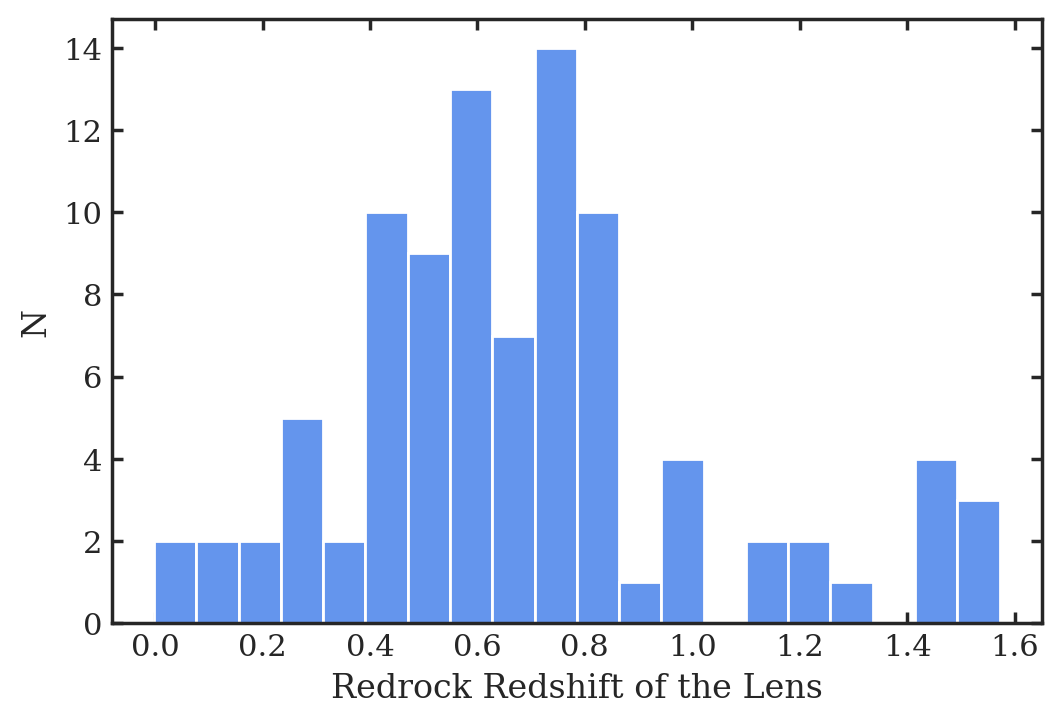

In [15]:
# histogram redshifts of known lenses
z = strongLensTargs['Z']

fig, ax = plt.subplots()

ax.hist(z, color='cornflowerblue', bins=20)
ax.set_ylabel('N')
ax.set_xlabel('Redrock Redshift of the Lens')

Text(0.5, 0, 'Delta Chi Squared')

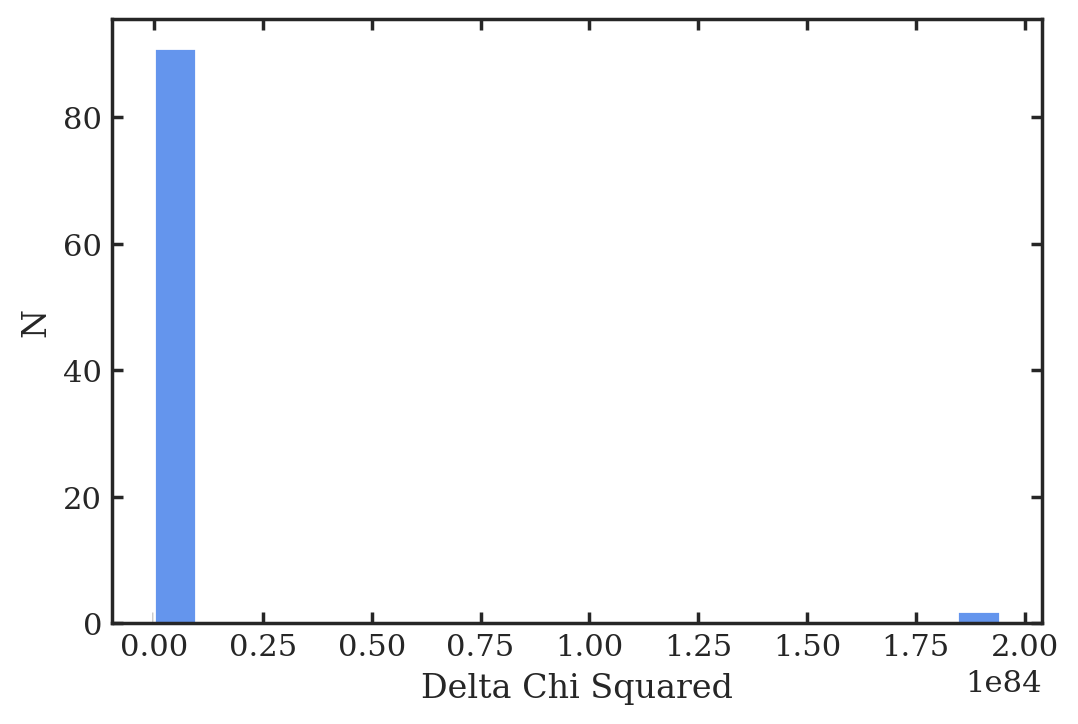

In [8]:
# histogram redshifts of known lenses
chi2 = strongLensTargs['DELTACHI2']

fig, ax = plt.subplots()

ax.hist(chi2, color='cornflowerblue', bins=20)
ax.set_ylabel('N')
ax.set_xlabel('Delta Chi Squared')